# Apr 29th, 2022 (ROI sizes 2d & 3d)

**Motivation**: Distribution of ROI sizes both 2d (surface area) and 3d (volume). <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from numpy.ma import masked_where as mwh
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
fig_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# HIDE CODE


def plot_roi_2d():
    fig, axes = create_figure(2, 2, (13, 7.5), width_ratios=[1.6, 1])
    
    # top
    a = 100 * (min(region_sizes_top.values()) // 100)
    b = 100 * (max(region_sizes_top.values()) // 100 + 1)
    if mice.cfg.nn == 512:
        bins = np.linspace(a, b, (b - a) // 100 + 1)
    else:
        bins = np.linspace(a, b, (b - a) // 500 + 1)
        
    sns.histplot(region_sizes_top.values(), bins=bins, legend=False, ax=axes[0, 0])
    mu = np.mean(list(region_sizes_top.values()))
    axes[0, 0].axvline(mu, color='r', ls='--', label=f'mean ~ {mu:0.0f}')
    axes[0, 0].legend(fontsize=13, loc='upper left')
    axes[0, 0].grid(axis='y')

    top_tr, x_top_tr = filter_boundaries([top, x_top], top > 0)
    axes[0, 1].imshow(mwh(top_tr == 0, top_tr), cmap='Greys_r')
    axes[0, 1].imshow(mwh(x_top_tr == 0, x_top_tr), cmap='Spectral')
    remove_ticks(axes[0, 1])
    
    #flat
    a = 500 * (min(region_sizes_flat.values()) // 500)
    b = 500 * (max(region_sizes_flat.values()) // 500 + 1)
    if mice.cfg.nn == 512:
        bins = np.linspace(a, b, (b - a) // 50 + 1)
    else:
        bins = np.linspace(a, b, (b - a) // 100 + 1)

    sns.histplot(region_sizes_flat.values(), bins=bins, legend=False, ax=axes[1, 0])
    mu = np.mean(list(region_sizes_flat.values()))
    axes[1, 0].axvline(mu, color='r', ls='--', label=f'mean ~ {mu:0.0f}')
    axes[1, 0].legend(fontsize=13, loc='upper left')
    axes[1, 0].grid(axis='y')

    flat_tr, x_flat_tr = filter_boundaries([flat, x_flat], flat > 0)
    axes[1, 1].imshow(mwh(flat_tr == 0, flat_tr), cmap='Greys_r')
    axes[1, 1].imshow(mwh(x_flat_tr == 0, x_flat_tr), cmap='Spectral')
    remove_ticks(axes[1, 1])

    axes[1, 0].set_xlabel(r'Size  [ $\times 10^{-4} \, mm^2$ ]', fontsize=17, labelpad=15)
    for ax in axes[:, 0].flat:
        ax.set_ylabel('Count', fontsize=17)
        ax.tick_params(axis='both', labelsize=13)

    title = f"Num ROIs (per hemisphere):  N = {mice.cfg.nn}    .   .   .    "
    title += f"Num accepted total (optical FOV):  N = {len(regions_fov)}"
    sup = fig.suptitle(title, fontsize=17, y=1.02)
    plt.show()
    
    return fig, sup



def plot_roi_3d():
    fig, axes = create_figure(1, 3, (13.5, 3.8), width_ratios=[1.8, 1, 0.7])


    if mice.cfg.nn == 512:
        a = 50 * (min(region_sizes_vol.values()) // 50)
        b = 50 * (max(region_sizes_vol.values()) // 50 + 1)
        bins = np.linspace(a, b, (b - a) // 10 + 1)
    else:
        a = 100 * (min(region_sizes_vol.values()) // 100)
        b = 100 * (max(region_sizes_vol.values()) // 100 + 1)
        bins = np.linspace(a, b, (b - a) // 20 + 1)
    
    sns.histplot(region_sizes_vol.values(), bins=bins, legend=False, ax=axes[0])
    mu = np.mean(list(region_sizes_vol.values()))
    axes[0].axvline(mu, color='r', ls='--', label=f'mean ~ {mu:0.0f}')
    axes[0].legend(fontsize=14, loc='upper right')
    axes[0].grid(axis='y')

    idx = 60
    x_vol = mice.parcel['cortex'][idx].copy()
    x_vol[~np.isin(x_vol, regions_fov)] = 0
    regions_x = np.unique(x_vol[x_vol.nonzero()])
    for i, r in enumerate(regions_x):
        x_vol[x_vol == r] = i + 1
    annot, temp, x_vol_tr = filter_boundaries(
        [mice.al.annotation[idx], mice.al.template[idx], x_vol],
        mice.al.annotation[idx] > 0)
    axes[1].imshow(mwh(annot == 0, temp), 'Greys_r')
    axes[1].imshow(mwh(x_vol_tr == 0, x_vol_tr), 'Spectral')

    idx = 45
    x_vol = mice.parcel['cortex'][..., idx].copy()
    x_vol[~np.isin(x_vol, regions_fov)] = 0
    regions_x = np.unique(x_vol[x_vol.nonzero()])
    for i, r in enumerate(regions_x):
        x_vol[x_vol == r] = i + 1
    annot, temp, x_vol_tr = filter_boundaries(
        [mice.al.annotation[..., idx], mice.al.template[..., idx], x_vol],
        mice.al.annotation[..., idx] > 0)
    axes[2].imshow(mwh(annot == 0, temp), 'Greys_r')
    axes[2].imshow(mwh(x_vol_tr == 0, x_vol_tr), 'Spectral')

    remove_ticks(axes[1:])

    axes[0].set_ylabel('Count', fontsize=17)
    axes[0].set_xlabel(r'Volume  [ $\times 10^{-3} \, mm^3$ ]', fontsize=17, labelpad=15)
    axes[0].tick_params(axis='both', labelsize=13)

    plt.show()
    
    return fig, None

## Fig dir

In [3]:
fig_kws = {
    'transparent': True,
    'bbox_inches': 'tight',
}
fig_dir = pjoin(fig_dir, 'parcellation')
os.makedirs(fig_dir, exist_ok=True)

In [4]:
res = {
    'bold': np.round(0.2 ** 3, 9),
    'ca2': np.round(0.05 ** 2, 9),
}
res

{'bold': 0.008, 'ca2': 0.0025}

## 64 * 3

In [5]:
mice = Mice((64, 3), load_allen=True)
top, flat = Base(Mice(128), mode='ca2').load_top_flat()

from register.register import Register
reg = Register(mice)
reg.set_mode('ca2')

regions_fov = reg.get_accepted_regions()
regions_fov = regions_fov['cortex']['acc']
len(regions_fov)

ROI lookup not found, time to run organize_func() . . .

combine metadata not found, time to run cat_data() . . .

Name: cortex . . . a total of: 90 regions accepted, 38 regions rejected.
accept ratio: 70.31 %, reject ratio: 29.69 %, using a presence threshold of 20.0 %

90

In [6]:
f = 'parcel2d-top_10um.nii.gz'
f = pjoin(mice.cfg.parcel_dir, f)
parc_top = ants.image_read(f).numpy()

f = 'parcel2d-flat_10um.nii.gz'
f = pjoin(mice.cfg.parcel_dir, f)
parc_flat = ants.image_read(f).numpy()

### Mk plts

In [7]:
# top
region_sizes_top = collections.Counter(parc_top[parc_top.nonzero()])
region_sizes_top = {r: region_sizes_top.get(r, 0) for r in regions_fov}
x_top = parc_top.copy()
x_top[~np.isin(x_top, regions_fov)] = 0
for i, r in enumerate(regions_fov):
    x_top[x_top == r] = i + 1

# flat
region_sizes_flat = collections.Counter(parc_flat[parc_flat.nonzero()])
region_sizes_flat = {r: region_sizes_flat.get(r, 0) for r in regions_fov}
x_flat = parc_flat.copy()
x_flat[~np.isin(x_flat, regions_fov)] = 0
for i, r in enumerate(regions_fov):
    x_flat[x_flat == r] = i + 1
    
# vol
region_sizes_vol = collections.Counter(mice.parcel['cortex'][mice.parcel['cortex'].nonzero()])
region_sizes_vol = {r: region_sizes_vol.get(r, 0) for r in regions_fov}
x_vol = mice.parcel['cortex'].copy()
x_vol[~np.isin(x_vol, regions_fov)] = 0
for i, r in enumerate(regions_fov):
    x_vol[x_vol == r] = i + 1

In [8]:
msg = f"Region sizes,\n"
msg += f"top\t. . .\tmin: {min(region_sizes_top.values())},\t\tmax: {max(region_sizes_top.values())}\n"
msg += f"flat\t. . .\tmin: {min(region_sizes_flat.values())},\tmax: {max(region_sizes_flat.values())}\n"
msg += f"vol\t. . .\tmin: {min(region_sizes_vol.values())},\tmax: {max(region_sizes_vol.values())}"
print(msg)

Region sizes,
top     . . .   min: 27,                max: 14676
flat    . . .   min: 13792,     max: 18150
vol     . . .   min: 179,       max: 884

In [9]:
msg = f"Region sizes,\n"

mu = np.mean(list(region_sizes_top.values()))
sd = np.std(list(region_sizes_top.values()))
msg += f"top\t. . .\tmean ± sd :  {mu:0.0f} ± {sd:0.0f} (10^-4 mm^2) \n"

mu = np.mean(list(region_sizes_flat.values()))
sd = np.std(list(region_sizes_flat.values()))
msg += f"flat\t. . .\tmean ± sd :  {mu:0.0f} ± {sd:0.0f} (10^-4 mm^2) \n"

mu = np.mean(list(region_sizes_vol.values()))
sd = np.std(list(region_sizes_vol.values()))
msg += f"vol\t. . .\tmean ± sd :  {mu:0.0f} ± {sd:0.0f} (10^-4 mm^2) \n"

print(msg)

Region sizes,
top     . . .   mean ± sd :  7548 ± 4713 (10^-4 mm^2) 
flat    . . .   mean ± sd :  15873 ± 890 (10^-4 mm^2) 
vol     . . .   mean ± sd :  498 ± 191 (10^-4 mm^2)

In [10]:
msg = f"Expected ROI sizes,\n"

mu = np.mean(list(region_sizes_top.values()))
sd = np.std(list(region_sizes_top.values()))
mu /= res['ca2'] * 1e4
sd /= res['ca2'] * 1e4
msg += f"top\t. . .\tmean ± sd :  {mu:0.0f} ± {sd:0.0f} pixels \n"

mu = np.mean(list(region_sizes_flat.values()))
sd = np.std(list(region_sizes_flat.values()))
mu /= res['ca2'] * 1e4
sd /= res['ca2'] * 1e4
msg += f"flat\t. . .\tmean ± sd :  {mu:0.0f} ± {sd:0.0f}  pixels \n"

mu = np.mean(list(region_sizes_vol.values()))
sd = np.std(list(region_sizes_vol.values()))
mu /= res['bold'] * 1e3
sd /= res['bold'] * 1e3
msg += f"vol\t. . .\tmean ± sd :  {mu:0.0f} ± {sd:0.0f}  voxels \n"

print(msg)

Expected ROI sizes,
top     . . .   mean ± sd :  302 ± 189 pixels 
flat    . . .   mean ± sd :  635 ± 36  pixels 
vol     . . .   mean ± sd :  62 ± 24  voxels

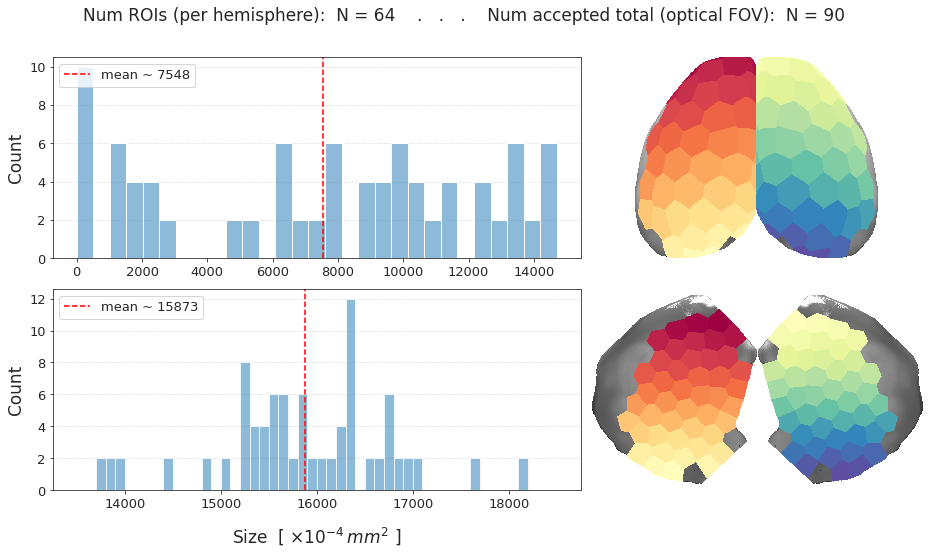

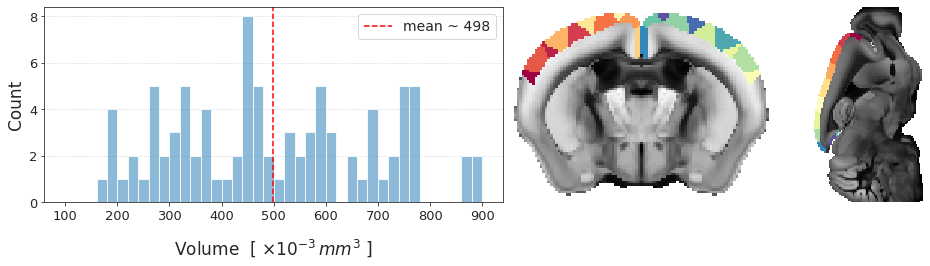

In [11]:
f2d, s2d = plot_roi_2d()
f3d, s3d = plot_roi_3d()

In [12]:
save_fig([f2d, f3d], [s2d, s3d], pjoin(fig_dir, f'ROI-sizes-n{mice.cfg.nn}.pdf'), multi=True)

## 128 * 3

In [13]:
mice = Mice((128, 3), load_allen=True)
base = Base(mice, mode='ca2')
top, flat = base.load_top_flat()

regions_fov = [
    mice.parcel.encode(lbl) for lbl
    in mice.node_lookup['ca2'].values()
]
len(regions_fov)

154

In [14]:
f = 'parcel2d-top_10um.nii.gz'
f = pjoin(mice.cfg.parcel_dir, f)
parc_top = ants.image_read(f).numpy()

f = 'parcel2d-flat_10um.nii.gz'
f = pjoin(mice.cfg.parcel_dir, f)
parc_flat = ants.image_read(f).numpy()

### Mk plts

In [15]:
# top
region_sizes_top = collections.Counter(parc_top[parc_top.nonzero()])
region_sizes_top = {r: region_sizes_top.get(r, 0) for r in regions_fov}
x_top = parc_top.copy()
x_top[~np.isin(x_top, regions_fov)] = 0
for i, r in enumerate(regions_fov):
    x_top[x_top == r] = i + 1

# flat
region_sizes_flat = collections.Counter(parc_flat[parc_flat.nonzero()])
region_sizes_flat = {r: region_sizes_flat.get(r, 0) for r in regions_fov}
x_flat = parc_flat.copy()
x_flat[~np.isin(x_flat, regions_fov)] = 0
for i, r in enumerate(regions_fov):
    x_flat[x_flat == r] = i + 1
    
# vol
region_sizes_vol = collections.Counter(mice.parcel['cortex'][mice.parcel['cortex'].nonzero()])
region_sizes_vol = {r: region_sizes_vol.get(r, 0) for r in regions_fov}
x_vol = mice.parcel['cortex'].copy()
x_vol[~np.isin(x_vol, regions_fov)] = 0
for i, r in enumerate(regions_fov):
    x_vol[x_vol == r] = i + 1

In [16]:
msg = f"Region sizes,\n"
msg += f"top\t. . .\tmin: {min(region_sizes_top.values())},\t\tmax: {max(region_sizes_top.values())}\n"
msg += f"flat\t. . .\tmin: {min(region_sizes_flat.values())},\tmax: {max(region_sizes_flat.values())}\n"
msg += f"vol\t. . .\tmin: {min(region_sizes_vol.values())},\tmax: {max(region_sizes_vol.values())}"
print(msg)

Region sizes,
top     . . .   min: 0,         max: 7940
flat    . . .   min: 6888,      max: 9004
vol     . . .   min: 83,        max: 476

In [17]:
msg = f"Region sizes,\n"
msg += f"top\t. . .\tmean ± sd :  {np.mean(list(region_sizes_top.values())):0.0f}"
msg += f" ± {np.std(list(region_sizes_top.values())):0.0f} (10^-4 mm^2) \n"
msg += f"flat\t. . .\tmean ± sd :  {np.mean(list(region_sizes_flat.values())):0.0f}"
msg += f" ± {np.std(list(region_sizes_flat.values())):0.0f} (10^-4 mm^2) \n"
msg += f"vol\t. . .\tmean ± sd :  {np.mean(list(region_sizes_vol.values())):0.0f}"
msg += f" ± {np.std(list(region_sizes_vol.values())):0.0f} (10^-3 mm^3) \n"
print(msg)

Region sizes,
top     . . .   mean ± sd :  4395 ± 2179 (10^-4 mm^2) 
flat    . . .   mean ± sd :  8039 ± 440 (10^-4 mm^2) 
vol     . . .   mean ± sd :  266 ± 103 (10^-3 mm^3)

In [18]:
msg = f"Expected ROI sizes,\n"

mu = np.mean(list(region_sizes_top.values()))
sd = np.std(list(region_sizes_top.values()))
mu /= res['ca2'] * 1e4
sd /= res['ca2'] * 1e4
msg += f"top\t. . .\tmean ± sd :  {mu:0.0f} ± {sd:0.0f} pixels \n"

mu = np.mean(list(region_sizes_flat.values()))
sd = np.std(list(region_sizes_flat.values()))
mu /= res['ca2'] * 1e4
sd /= res['ca2'] * 1e4
msg += f"flat\t. . .\tmean ± sd :  {mu:0.0f} ± {sd:0.0f} pixels \n"

mu = np.mean(list(region_sizes_vol.values()))
sd = np.std(list(region_sizes_vol.values()))
mu /= res['bold'] * 1e3
sd /= res['bold'] * 1e3
msg += f"vol\t. . .\tmean ± sd :  {mu:0.0f} ± {sd:0.0f}  voxels \n"

print(msg)

Expected ROI sizes,
top     . . .   mean ± sd :  176 ± 87 pixels 
flat    . . .   mean ± sd :  322 ± 18 pixels 
vol     . . .   mean ± sd :  33 ± 13  voxels

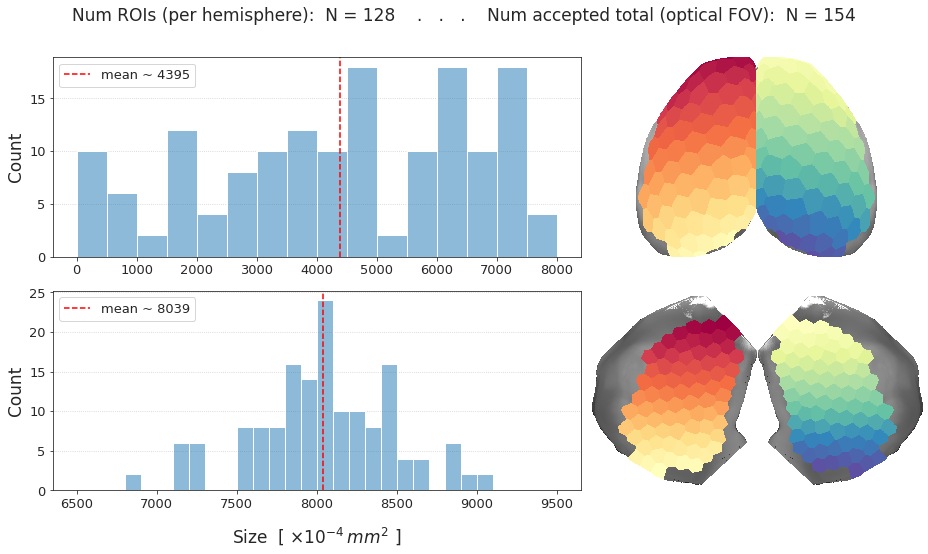

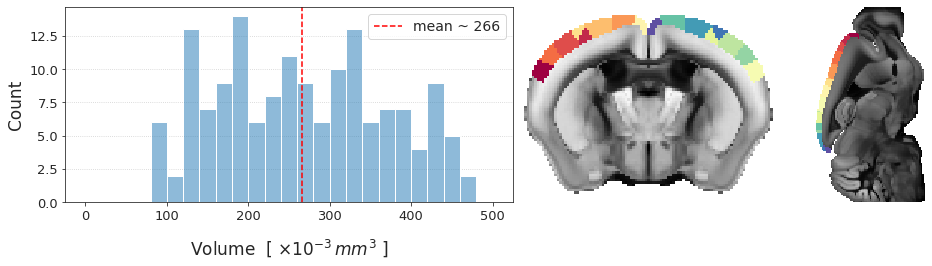

In [19]:
f2d, s2d = plot_roi_2d()
f3d, s3d = plot_roi_3d()

In [20]:
save_fig([f2d, f3d], [s2d, s3d], pjoin(fig_dir, f'ROI-sizes-n{mice.cfg.nn}.pdf'), multi=True)

## 512 * 3

In [5]:
mice = Mice((512, 3), load_allen=True)
base = Base(mice, mode='ca2')
top, flat = base.load_top_flat()

regions_fov = [
    mice.parcel.encode(lbl) for lbl
    in mice.node_lookup['ca2'].values()
]
len(regions_fov)

542

In [6]:
f = 'parcel2d-top_10um.nii.gz'
f = pjoin(mice.cfg.parcel_dir, f)
parc_top = ants.image_read(f).numpy()

f = 'parcel2d-flat_10um.nii.gz'
f = pjoin(mice.cfg.parcel_dir, f)
parc_flat = ants.image_read(f).numpy()

### Mk plts

In [7]:
# top
region_sizes_top = collections.Counter(parc_top[parc_top.nonzero()])
region_sizes_top = {r: region_sizes_top.get(r, 0) for r in regions_fov}
x_top = parc_top.copy()
x_top[~np.isin(x_top, regions_fov)] = 0
for i, r in enumerate(regions_fov):
    x_top[x_top == r] = i + 1

# flat
region_sizes_flat = collections.Counter(parc_flat[parc_flat.nonzero()])
region_sizes_flat = {r: region_sizes_flat.get(r, 0) for r in regions_fov}
x_flat = parc_flat.copy()
x_flat[~np.isin(x_flat, regions_fov)] = 0
for i, r in enumerate(regions_fov):
    x_flat[x_flat == r] = i + 1
    
# vol
region_sizes_vol = collections.Counter(mice.parcel['cortex'][mice.parcel['cortex'].nonzero()])
region_sizes_vol = {r: region_sizes_vol.get(r, 0) for r in regions_fov}
x_vol = mice.parcel['cortex'].copy()
x_vol[~np.isin(x_vol, regions_fov)] = 0
for i, r in enumerate(regions_fov):
    x_vol[x_vol == r] = i + 1

In [8]:
msg = f"Region sizes,\n"
msg += f"top\t. . .\tmin: {min(region_sizes_top.values())},\t\tmax: {max(region_sizes_top.values())}\n"
msg += f"flat\t. . .\tmin: {min(region_sizes_flat.values())},\tmax: {max(region_sizes_flat.values())}\n"
msg += f"vol\t. . .\tmin: {min(region_sizes_vol.values())},\tmax: {max(region_sizes_vol.values())}"
print(msg)

Region sizes,
top     . . .   min: 0,         max: 2167
flat    . . .   min: 1718,      max: 2274
vol     . . .   min: 19,        max: 125

In [9]:
msg = f"Region sizes,\n"
msg += f"top\t. . .\tmean ± sd :  {np.mean(list(region_sizes_top.values())):0.0f}"
msg += f" ± {np.std(list(region_sizes_top.values())):0.0f} (10^-4 mm^2) \n"
msg += f"flat\t. . .\tmean ± sd :  {np.mean(list(region_sizes_flat.values())):0.0f}"
msg += f" ± {np.std(list(region_sizes_flat.values())):0.0f} (10^-4 mm^2) \n"
msg += f"vol\t. . .\tmean ± sd :  {np.mean(list(region_sizes_vol.values())):0.0f}"
msg += f" ± {np.std(list(region_sizes_vol.values())):0.0f} (10^-3 mm^3) \n"
print(msg)

Region sizes,
top     . . .   mean ± sd :  1202 ± 489 (10^-4 mm^2) 
flat    . . .   mean ± sd :  1981 ± 109 (10^-4 mm^2) 
vol     . . .   mean ± sd :  67 ± 25 (10^-3 mm^3)

In [10]:
msg = f"Expected ROI sizes,\n"

mu = np.mean(list(region_sizes_top.values()))
sd = np.std(list(region_sizes_top.values()))
mu /= res['ca2'] * 1e4
sd /= res['ca2'] * 1e4
msg += f"top\t. . .\tmean ± sd :  {mu:0.0f} ± {sd:0.0f} pixels \n"

mu = np.mean(list(region_sizes_flat.values()))
sd = np.std(list(region_sizes_flat.values()))
mu /= res['ca2'] * 1e4
sd /= res['ca2'] * 1e4
msg += f"flat\t. . .\tmean ± sd :  {mu:0.0f} ± {sd:0.0f}  pixels \n"

mu = np.mean(list(region_sizes_vol.values()))
sd = np.std(list(region_sizes_vol.values()))
mu /= res['bold'] * 1e3
sd /= res['bold'] * 1e3
msg += f"vol\t. . .\tmean ± sd :  {mu:0.0f} ± {sd:0.0f}  voxels \n"

print(msg)

Expected ROI sizes,
top     . . .   mean ± sd :  48 ± 20 pixels 
flat    . . .   mean ± sd :  79 ± 4  pixels 
vol     . . .   mean ± sd :  8 ± 3  voxels

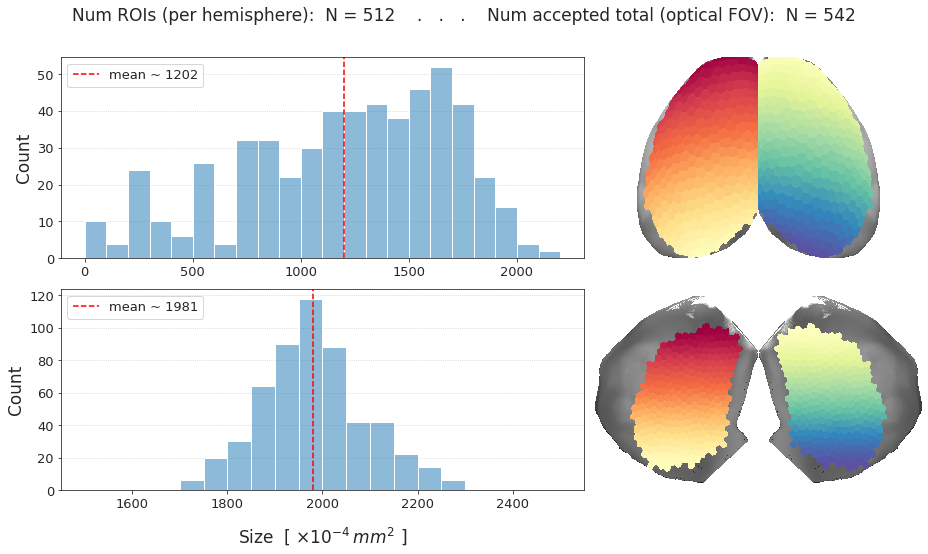

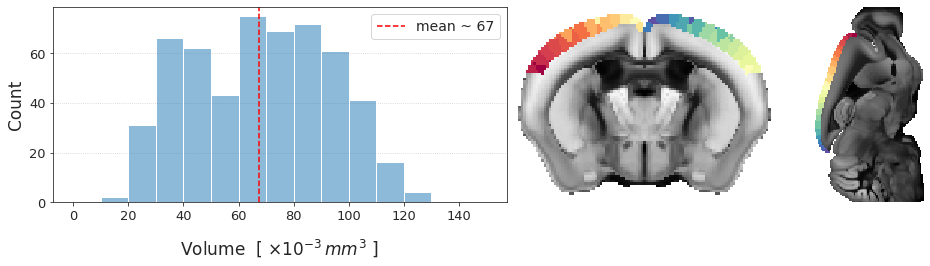

In [11]:
f2d, s2d = plot_roi_2d()
f3d, s3d = plot_roi_3d()

In [12]:
save_fig([f2d, f3d], [s2d, s3d], pjoin(fig_dir, f'ROI-sizes-n{mice.cfg.nn}.pdf'), multi=True)